**Code from:**  
[Facial Similarity with Siamese Networks in PyTorch](https://medium.com/hackernoon/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7)

In [15]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git

Cloning into 'Facial-Similarity-with-Siamese-Networks-in-Pytorch'...
remote: Enumerating objects: 532, done.
remote: Total 532 (delta 0), reused 0 (delta 0), pack-reused 532
Receiving objects: 100% (532/532), 6.32 MiB | 9.45 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
import random
import tqdm
import PIL
from PIL import Image,ImageOps
import numpy as np
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [0]:
class Config():
    training_dir = "/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training"
    testing_dir = "/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing"
    train_batch_size = 64
    train_number_epochs = 100

In [0]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn1 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(1, 4, 3),
        nn.BatchNorm2d(4),
        nn.ReLU(True),

        nn.ReflectionPad2d(1),
        nn.Conv2d(4, 8, 3),
        nn.BatchNorm2d(8),
        nn.ReLU(True),

        nn.ReflectionPad2d(1),
        nn.Conv2d(8,8,3),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
    )

    self.fc1 = nn.Sequential(
        nn.Linear(8*100*100, 500),
        nn.ReLU(True),

        nn.Linear(500,500),
        nn.ReLU(True),

        nn.Linear(500, 5)
    )
  def forward_once(self, x):
    output = self.cnn1(x)
    output = output.view(output.size(0),-1)
    output = self.fc1(output)
    return output

  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2

In [0]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=2.):
    super().__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                                  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.), 2))
    return loss_contrastive

In [0]:
class SiameseNetworkDataset(Dataset):
  def __init__(self, imageFolderDataset, transform=None, should_invert=True):
    self.imageFolderDataset = imageFolderDataset
    self.transform = transform
    self.should_invert = should_invert

  def __getitem__(self, index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs) #[img_path, label]
    should_get_same_class = random.randint(0,1) # randomly choose 0 or 1

    if should_get_same_class:
      while True:
        img1_tuple = random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] == img1_tuple[1]:
          break

    else:
      img1_tuple = random.choice(self.imageFolderDataset.imgs)

    img0 = Image.open(img0_tuple[0])
    img1 = Image.open(img1_tuple[0])
    img0 = img0.convert("L")
    img1 = img1.convert("L")

    if self.should_invert:
      img0 = PIL.ImageOps.invert(img0)
      img1 = PIL.ImageOps.invert(img1)

    if self.transform:
      img0 = self.transform(img0)
      img1 = self.transform(img1)

    label = torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])], dtype = np.float32))

    return img0, img1, label

  def __len__(self):
    return len(self.imageFolderDataset.imgs)


In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform = transforms.Compose([
                                                                        transforms.Resize((100,100)),
                                                                        transforms.ToTensor(),
                                                                        #transforms.Normalize([.5],[.5])
                                                                        ]),should_invert=False
                                        )

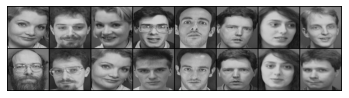

[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [45]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [0]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=4, batch_size=Config.train_batch_size)

Epoch number 0
 Current loss 10.10914421081543




Epoch number 1
 Current loss 8.661036491394043




Epoch number 2
 Current loss 6.778116226196289




Epoch number 3
 Current loss 7.10882043838501




Epoch number 4
 Current loss 7.264636516571045




Epoch number 5
 Current loss 7.395907878875732




Epoch number 6
 Current loss 7.08753776550293




Epoch number 7
 Current loss 7.25302791595459




Epoch number 8
 Current loss 6.886684417724609




Epoch number 9
 Current loss 7.169138431549072




Epoch number 10
 Current loss 7.735415458679199




Epoch number 11
 Current loss 7.396606922149658




Epoch number 12
 Current loss 7.4972944259643555




Epoch number 13
 Current loss 6.736126899719238




Epoch number 14
 Current loss 7.395102024078369




Epoch number 15
 Current loss 7.035466194152832




Epoch number 16
 Current loss 7.114863872528076




Epoch number 17
 Current loss 6.558601379394531




Epoch number 18
 Current loss 7.168436050415039




Epoch number 19
 Current loss 7.430244445800781




Epoch number 20
 Current loss 7.576301574707031




Epoch number 21
 Current loss 7.192259311676025




Epoch number 22
 Current loss 7.147886753082275




Epoch number 23
 Current loss 7.435274124145508




Epoch number 24
 Current loss 6.815051078796387




Epoch number 25
 Current loss 7.55309534072876




Epoch number 26
 Current loss 7.02730131149292




Epoch number 27
 Current loss 7.646336555480957




Epoch number 28
 Current loss 6.9059157371521




Epoch number 29
 Current loss 6.9211835861206055




Epoch number 30
 Current loss 7.030404090881348




Epoch number 31
 Current loss 6.537772178649902




Epoch number 32
 Current loss 7.127110481262207




Epoch number 33
 Current loss 7.059081077575684




Epoch number 34
 Current loss 7.731899261474609




Epoch number 35
 Current loss 7.0016560554504395




Epoch number 36
 Current loss 7.617613792419434




Epoch number 37
 Current loss 7.209750175476074




Epoch number 38
 Current loss 6.767329216003418




Epoch number 39
 Current loss 7.379810333251953




Epoch number 40
 Current loss 6.492076873779297




Epoch number 41
 Current loss 7.212215423583984




Epoch number 42
 Current loss 6.675787448883057




Epoch number 43
 Current loss 6.976198196411133




Epoch number 44
 Current loss 6.873227119445801




Epoch number 45
 Current loss 8.07088851928711




Epoch number 46
 Current loss 6.994452953338623




Epoch number 47
 Current loss 6.948803901672363




Epoch number 48
 Current loss 6.919956684112549




Epoch number 49
 Current loss 6.929722785949707




Epoch number 50
 Current loss 7.113151550292969




Epoch number 51
 Current loss 7.27495813369751




Epoch number 52
 Current loss 6.791689872741699




Epoch number 53
 Current loss 7.408491611480713




Epoch number 54
 Current loss 6.995479583740234




Epoch number 55
 Current loss 7.075408458709717




Epoch number 56
 Current loss 6.881864547729492




Epoch number 57
 Current loss 7.213283538818359




Epoch number 58
 Current loss 6.919347763061523




Epoch number 59
 Current loss 7.178340911865234




Epoch number 60
 Current loss 7.607658386230469




Epoch number 61
 Current loss 7.4656596183776855




Epoch number 62
 Current loss 7.446584701538086




Epoch number 63
 Current loss 7.17292594909668




Epoch number 64
 Current loss 7.221466064453125




Epoch number 65
 Current loss 7.563314914703369




Epoch number 66
 Current loss 7.074973106384277




Epoch number 67
 Current loss 6.277860641479492




Epoch number 68
 Current loss 6.948751449584961




Epoch number 69
 Current loss 7.254481315612793




Epoch number 70
 Current loss 7.140172004699707




Epoch number 71
 Current loss 6.594902515411377




Epoch number 72
 Current loss 6.82312536239624




Epoch number 73
 Current loss 7.109733581542969




Epoch number 74
 Current loss 6.968125343322754




Epoch number 75
 Current loss 7.272233963012695




Epoch number 76
 Current loss 6.787688255310059




Epoch number 77
 Current loss 7.138064384460449




Epoch number 78
 Current loss 7.049128532409668




Epoch number 79
 Current loss 7.135238170623779




Epoch number 80
 Current loss 6.801862716674805




Epoch number 81
 Current loss 6.653571128845215




Epoch number 82
 Current loss 6.919155120849609




Epoch number 83
 Current loss 7.4283647537231445




Epoch number 84
 Current loss 6.668222427368164




Epoch number 85
 Current loss 7.216265678405762




Epoch number 86
 Current loss 6.678986549377441




Epoch number 87
 Current loss 6.605679988861084




Epoch number 88
 Current loss 7.05006742477417




Epoch number 89
 Current loss 6.856624126434326




Epoch number 90
 Current loss 6.9232611656188965




Epoch number 91
 Current loss 6.83840799331665




Epoch number 92
 Current loss 6.956829071044922




Epoch number 93
 Current loss 6.831749439239502




Epoch number 94
 Current loss 7.49092960357666




Epoch number 95
 Current loss 7.090483665466309




Epoch number 96
 Current loss 7.337589263916016




Epoch number 97
 Current loss 6.808286666870117




Epoch number 98
 Current loss 6.993075370788574




Epoch number 99
 Current loss 7.218602657318115




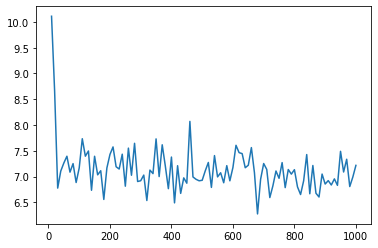

In [52]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss(5.0)
optimizer = optim.Adam(net.parameters(), lr= 5e-4)

counter = []
loss_history = []
iteration_number=0

for epoch in range(0, Config.train_number_epochs):
  for i, (img0, img1, label) in enumerate(tqdm.notebook.tqdm(train_dataloader), 0):
    img0, img1, label = img0.to(device), img1.to(device), label.to(device)
    optimizer.zero_grad()
    output1, output2 = net(img0, img1)
    loss = criterion(output1, output2, label)
    loss.backward()
    optimizer.step()
    if i %10 == 0 :
        print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
        iteration_number +=10
        counter.append(iteration_number)
        loss_history.append(loss.item())
show_plot(counter,loss_history)

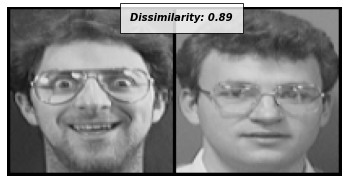

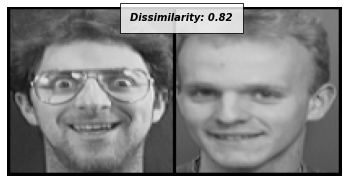

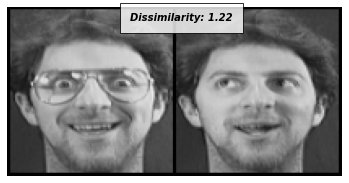

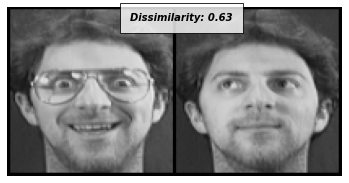

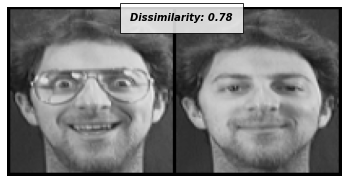

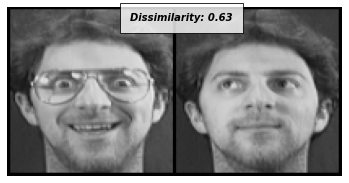

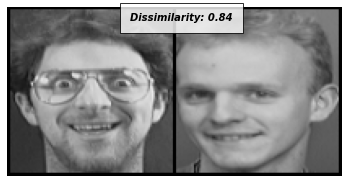

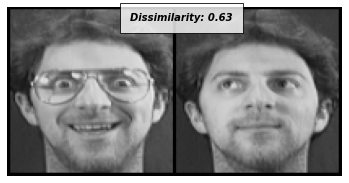

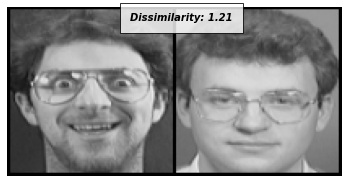

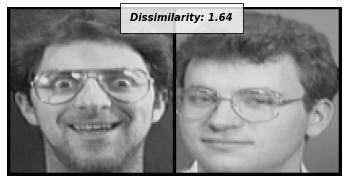

In [54]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))